# Описание

В этом ноутбуке будут представлены основные алгоритмы классификации сердечных ритмов по данным ЭКГ.

https://www.kaggle.com/erhmrai/ecg-image-data

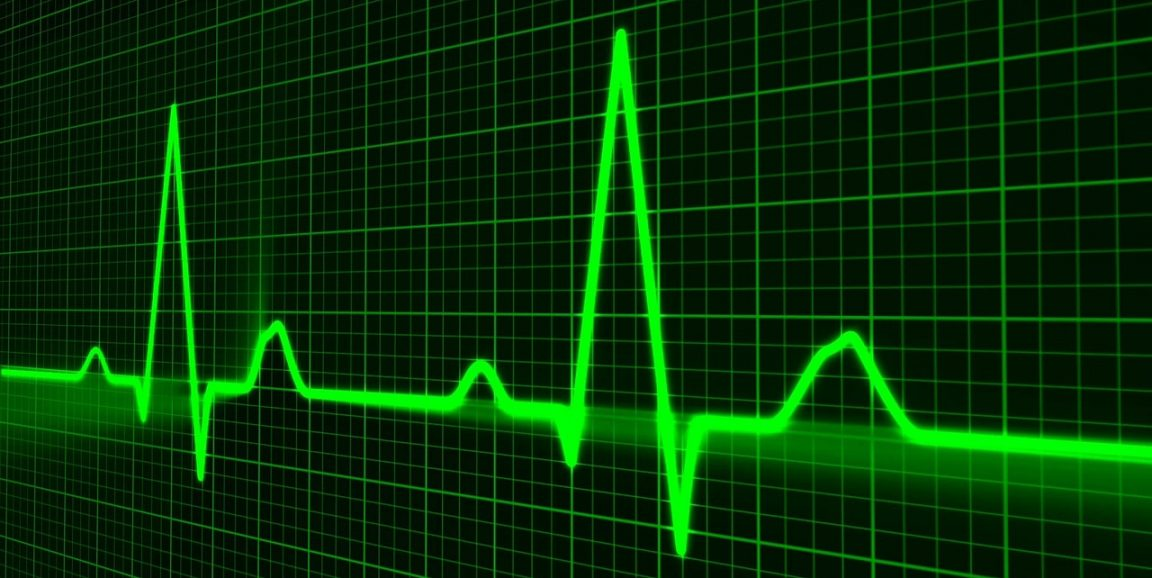

# Импорт библиотек и чтение данных

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [55]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["figure.autolayout"] = True
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [56]:
train = pd.read_csv(r'D:\Big Datasets\heartbeat\mitbih_train.csv', header=None)
test = pd.read_csv(r'D:\Big Datasets\heartbeat\mitbih_test.csv', header=None)

In [57]:
%run reduce_memory_usage.py

<Figure size 720x432 with 0 Axes>

In [58]:
train = reduce_mem_usage(train)

Mem. usage decreased to 31.40 Mb (75.0% reduction)


In [59]:
test = reduce_mem_usage(test)

Mem. usage decreased to  7.85 Mb (75.0% reduction)


In [60]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

In [61]:
def oversampling(train_df, test_df):
    df = pd.concat([train_df, test_df])
    train = df[:train_df.shape[0]]
    test = df[train_df.shape[0]:df.shape[0]]
    
    X = train.drop(columns=187)
    y = train[187]
    r_X, r_y = oversample.fit_resample(X, y)
    return r_X, r_y

In [62]:
X_train = train.drop(columns=187)
y_train = train[187].astype(int)
X_test = test.drop(columns=187)
y_test = test[187].astype(int)

In [63]:
X_train.shape

(87554, 187)

In [64]:
X_test.shape

(21892, 187)

In [65]:
correlations = train.corr()

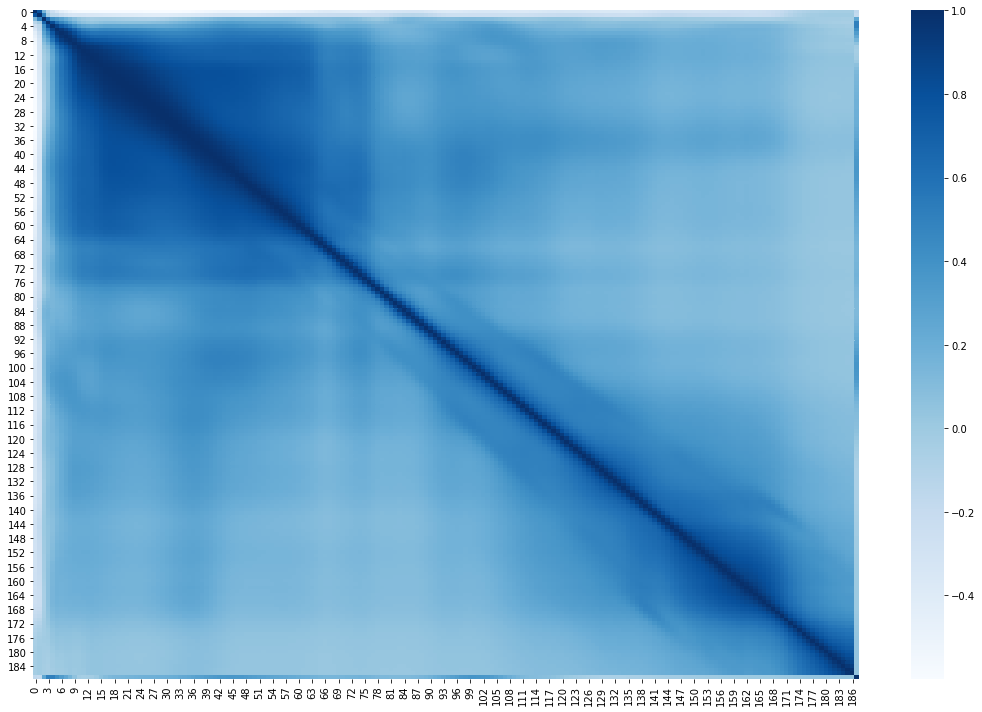

In [66]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlations, cmap='Blues');

In [118]:
s = train.sample(1).transpose()[:-1] #Данные для одного из фрагментов ЭКГ

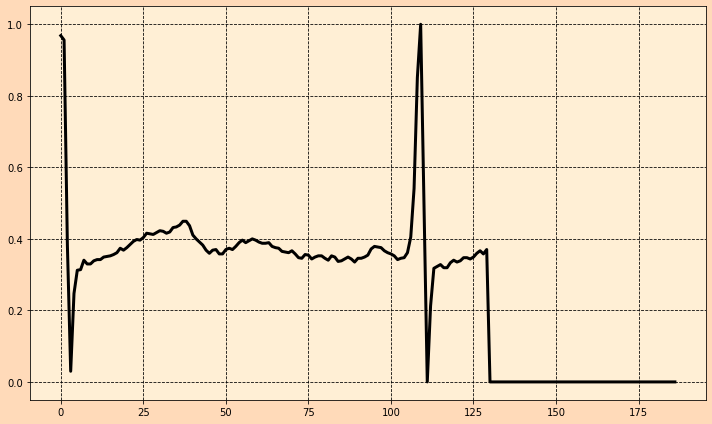

In [119]:
fig = plt.figure(facecolor='peachpuff')
ax = plt.axes()
ax.set_facecolor('papayawhip')
plt.plot(s, lw=3, color='k')
plt.grid(True, color='k', ls='--')
plt.show()

In [69]:
classes_size = y_train.value_counts()
classes_size

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64

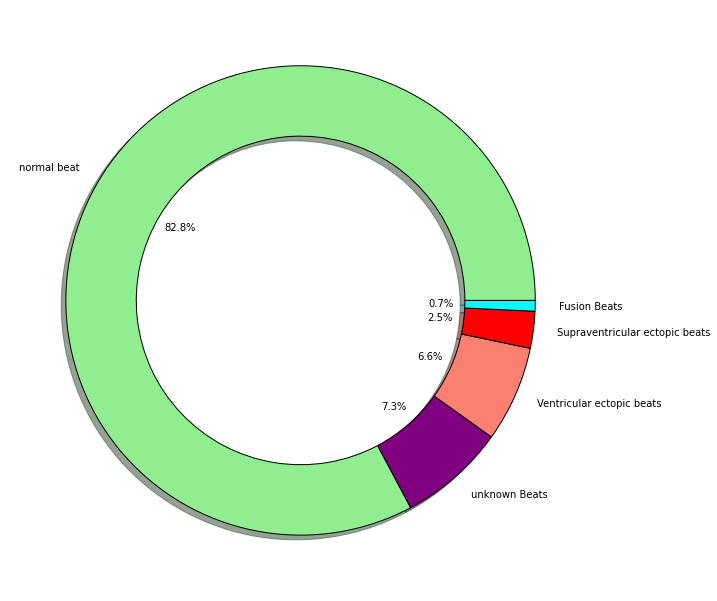

In [70]:
plt.figure(figsize=(10,10))
plt.pie(classes_size, wedgeprops = dict(width = 0.3, edgecolor = 'k', linewidth = 1), 
        labels=['normal beat','unknown Beats','Ventricular ectopic beats',
                'Supraventricular ectopic beats','Fusion Beats'], 
        colors=['lightgreen', 'purple', 'salmon', 'red', 'cyan'],autopct='%1.1f%%', shadow=True)
plt.show()

Необходимо сбалансировать данные 

In [71]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# Базовые модели

## XGBoost

In [72]:
xgb = XGBClassifier(n_jobs=-1)

In [73]:
# %time
# xgb.fit(X_train, y_train)

In [74]:
from joblib import dump, load

In [75]:
# dump(xgb, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\xgb_ecg_clf.joblib') 

xgb = load(r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\xgb_ecg_clf.joblib')

y_pred_xgb = xgb.predict(X_test)

In [76]:
xgb_score = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred_xgb))
xgb_score

,0,1,2,3,4
0,0.981165,0.946835,0.968590,0.879699,0.993003
1,0.997682,0.672662,0.915746,0.722222,0.970771
2,0.989354,0.786540,0.941427,0.793220,0.981761
3,18118.000000,556.000000,1448.000000,162.000000,1608.000000


## LightGBM

In [77]:
from lightgbm import LGBMClassifier

In [78]:
lgb = LGBMClassifier(n_jobs=-1)

In [79]:
# lgb.fit(X_train, y_train)

In [80]:
# dump(lgb, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\lgb_ecg_clf.joblib') 

lgb = load(r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\lgb_ecg_clf.joblib')

y_pred_lgb = lgb.predict(X_test)

lgb_score = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred_lgb))
lgb_score

,0,1,2,3,4
0,0.979865,0.927461,0.967057,0.783217,0.992998
1,0.996523,0.643885,0.912293,0.691358,0.970149
2,0.988124,0.760085,0.938877,0.734426,0.981441
3,18118.000000,556.000000,1448.000000,162.000000,1608.000000


## RandomForest

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

In [83]:
# rf.fit(X_train, y_train)

In [84]:
# dump(rf, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\rf_ecg_clf.joblib') 

rf = load(r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\rf_ecg_clf.joblib')

y_pred_rf = rf.predict(X_test)

rf_score = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred_rf))
rf_score

,0,1,2,3,4
0,0.971550,0.965015,0.983581,0.826087,0.995413
1,0.998951,0.595324,0.868785,0.586420,0.944652
2,0.985060,0.736374,0.922626,0.685921,0.969368
3,18118.000000,556.000000,1448.000000,162.000000,1608.000000


## Многослойный персептрон (MLP)

Для отпимизации в задаче мультиклассовой классификации будем использовать функцию потерь sparse_categorical_crossentropy

In [85]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [86]:
n_features = X_train.shape[1]

### MLP с линейной ФА

In [87]:
mlp_model_lin = tf.keras.Sequential()

In [88]:
# mlp_model_lin.add(Dense(10, activation='linear', kernel_initializer='he_normal', input_shape=(n_features,)))
# mlp_model_lin.add(Dense(8, activation='linear', kernel_initializer='he_normal'))
# mlp_model_lin.add(Dense(5, activation='softmax'))

# # compile the mlp_model_lin
# mlp_model_lin.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # fit the mlp_model_lin
# mlp_model_lin.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# # evaluate the mlp_model_lin
# loss, acc = mlp_model_lin.evaluate(X_test, y_test)

# print('Test Accuracy: %.3f' % acc)

In [89]:
# mlp_model_lin.save(r'C:\Users\Максим\Desktop\Аналитика данных\Нейросети\mlp_model_lin_ecg_clf.h5')
mlp_model_lin = load_model(r'C:\Users\Максим\Desktop\Аналитика данных\Нейросети\mlp_model_lin_ecg_clf.h5')

In [90]:
y_pred_mlp = mlp_model_lin.predict(X_test)
classes_mlp = np.argmax(y_pred_mlp, axis=1)

In [91]:
mlp_lin_score = pd.DataFrame(classification_report(y_test, classes_mlp, output_dict=True)).T.iloc[:5].iloc[:, :3]
mlp_lin_score

,precision,recall,f1-score
0,0.926111,0.982338,0.953396
1,0.844828,0.440647,0.579196
2,0.638132,0.339779,0.443443
3,0.641791,0.265432,0.375546
4,0.923027,0.887438,0.904883


### MLP с сигмоидной ФА

In [92]:
mlp_model_sigm = tf.keras.Sequential()

In [93]:
# mlp_model_sigm.add(Dense(10, activation='sigmoid', kernel_initializer='he_normal', input_shape=(n_features,)))
# mlp_model_sigm.add(Dense(8, activation='sigmoid', kernel_initializer='he_normal'))
# mlp_model_sigm.add(Dense(5, activation='softmax'))

# # compile the mlp_model_sigm
# mlp_model_sigm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # fit the mlp_model_sigm
# mlp_model_sigm.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# # evaluate the mlp_model_sigm
# loss, acc = mlp_model_sigm.evaluate(X_test, y_test)

# print('Test Accuracy: %.3f' % acc)

In [94]:
# mlp_model_sigm.save(r'C:\Users\Максим\Desktop\Аналитика данных\Нейросети\mlp_model_sigm_ecg_clf.h5')
mlp_model_sigm = load_model(r'C:\Users\Максим\Desktop\Аналитика данных\Нейросети\mlp_model_sigm_ecg_clf.h5')

In [95]:
y_pred_mlp = mlp_model_sigm.predict(X_test)
classes_mlp = np.argmax(y_pred_mlp, axis=1)

In [96]:
# set(y_test) - set(classes_mlp)

In [97]:
mlp_sigm_score = pd.DataFrame(classification_report(y_test, classes_mlp, output_dict=True)).T.iloc[:5].iloc[:, :3]
mlp_sigm_score

,precision,recall,f1-score
0,0.966124,0.991666,0.978728
1,0.888889,0.517986,0.654545
2,0.865871,0.851519,0.858635
3,0.781250,0.308642,0.442478
4,0.976399,0.900498,0.936914


### MLP с ФА Relu

In [98]:
mlp_model_relu = tf.keras.Sequential()

In [99]:
n_features = X_train.shape[1]

In [100]:
# mlp_model_relu.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
# mlp_model_relu.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
# mlp_model_relu.add(Dense(5, activation='softmax'))

# # compile the mlp_model_relu
# mlp_model_relu.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # fit the mlp_model_relu
# mlp_model_history = mlp_model_relu.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# # evaluate the mlp_model_relu
# loss, acc = mlp_model_relu.evaluate(X_test, y_test)

# print('Test Accuracy: %.3f' % acc)

In [101]:
# mlp_model_relu.save(r'C:\Users\Максим\Desktop\Аналитика данных\Нейросети\mlp_model_relu_ecg_clf.h5')
mlp_model_relu = load_model(r'C:\Users\Максим\Desktop\Аналитика данных\Нейросети\mlp_model_relu_ecg_clf.h5')

https://alexlenail.me/NN-SVG/index.html

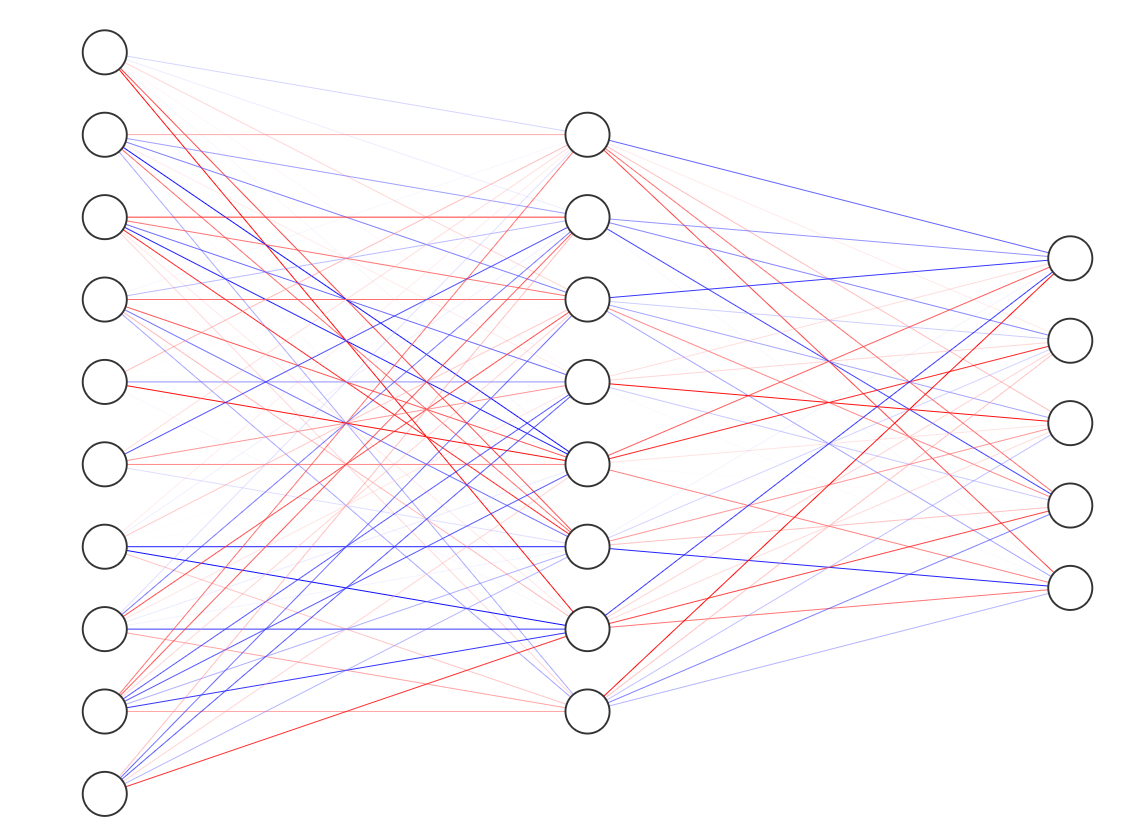

In [102]:
y_pred_mlp = mlp_model_relu.predict(X_test)
classes_mlp = np.argmax(y_pred_mlp, axis=1)

In [104]:
mpl_score = pd.DataFrame(precision_recall_fscore_support(y_test, classes_mlp))
mpl_score

,0,1,2,3,4
0,0.969308,0.837838,0.879190,0.767677,0.970336
1,0.988354,0.557554,0.869475,0.469136,0.915423
2,0.978739,0.669546,0.874306,0.582375,0.942080
3,18118.000000,556.000000,1448.000000,162.000000,1608.000000


## Сравнение ф-ий активации

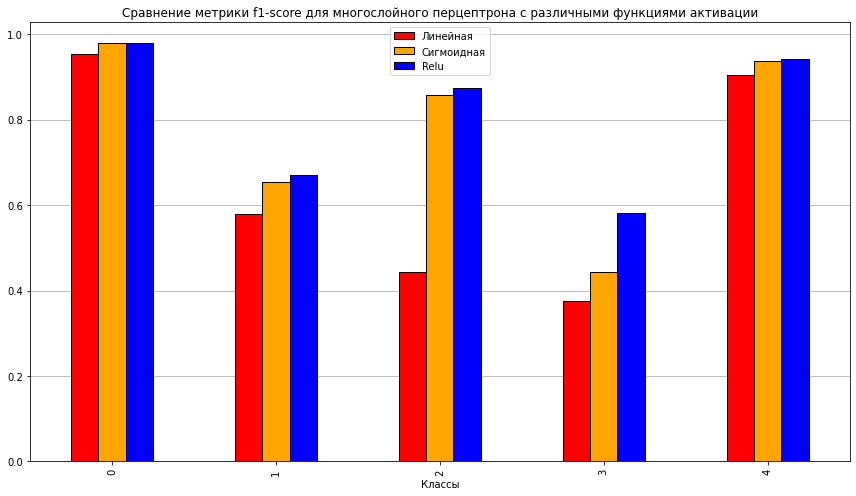

In [105]:
# plt.subplots(2)
pd.concat([mlp_lin_score['f1-score'], mlp_sigm_score['f1-score'], mlp_relu_score['f1-score']], 
          axis=1).plot(kind='bar', figsize=(12, 7), color=['r', 'orange', 'b'], ec='k', zorder=2)
plt.grid(True, axis='y')
plt.legend(['Линейная', 'Сигмоидная', 'Relu'], loc='best')
plt.xlabel('Классы')
plt.title(
    'Сравнение метрики f1-score для многослойного перцептрона с различными функциями активации'
);

Функция активации Relu наиболее оптимальна для этой задачи

# Улучшение модели

In [256]:
from imblearn.pipeline import Pipeline as imb_pipeline

In [257]:
from sklearn.model_selection import train_test_split

In [402]:
r_X, r_y = oversampling(train, test)

In [403]:
r_X.shape, r_y.shape

((362355, 187), (362355,))

In [404]:
X_train, X_test, y_train, y_test = train_test_split(r_X, r_y, test_size=0.2, random_state=42)

## XGBoost

In [261]:
xgb_os = XGBClassifier(n_jobs=-1)

In [263]:
# xgb_os.fit(X_train, y_train)

[11:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [264]:
# dump(xgb_os, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\xgb_os_ecg_clf.joblib') 

xgb_os = load(r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\xgb_os_ecg_clf.joblib')

In [265]:
y_pred_xgb_os = xgb_os.predict(X_test)

In [266]:
xgb_os_score = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred_xgb_os))
xgb_os_score

,0,1,2,3,4
0,0.979507,0.983313,0.993881,0.994486,0.998359
1,0.974969,0.985139,0.991262,0.999723,0.998496
2,0.977233,0.984225,0.992569,0.997097,0.998427
3,14462.000000,14535.000000,14419.000000,14432.000000,14623.000000


## LGBM

In [267]:
lgb_os = LGBMClassifier(n_jobs=-1)

In [268]:
lgb_os.fit(X_train, y_train)

LGBMClassifier()

In [270]:
# dump(lgb_os, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\lgb_os_ecg_clf.joblib') 

lgb_os = load(r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\lgb_os_ecg_clf.joblib')

y_pred_lgb_os = lgb_os.predict(X_test)

lgb_os_score = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred_lgb_os))
lgb_os_score

,0,1,2,3,4
0,0.977143,0.982145,0.992270,0.992361,0.997402
1,0.972549,0.983970,0.988141,0.999099,0.997607
2,0.974841,0.983057,0.990201,0.995719,0.997504
3,14462.000000,14535.000000,14419.000000,14432.000000,14623.000000


## Random Forest

In [271]:
rf_os = RandomForestClassifier(n_jobs=-1)

In [272]:
rf_os.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [273]:
# dump(rf_os, r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\rf_os_ecg_clf.joblib') 

rf_os = load(r'C:\Users\Максим\Desktop\Аналитика данных\Машинное обучение\Модели\rf_os_ecg_clf.joblib')

y_pred_rf_os = rf_os.predict(X_test)

In [274]:
rf_os_score = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred_rf_os))
rf_os_score

,0,1,2,3,4
0,0.993628,0.995192,0.997641,0.998409,0.999247
1,0.991979,0.996835,0.997087,0.999792,0.998427
2,0.992803,0.996013,0.997364,0.999100,0.998837
3,14462.000000,14535.000000,14419.000000,14432.000000,14623.000000


## MLP

In [284]:
mlp_os = tf.keras.Sequential()

In [409]:
mlp_os.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
mlp_os.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
mlp_os.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
mlp_os.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
mlp_os.add(Dense(5, activation='softmax'))

# compile the mlp_os
mlp_os.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the mlp_os
mlp_model_history = mlp_os.fit(X_train, y_train, epochs=30, batch_size=32, verbose=True)

# evaluate the mlp_os
loss, acc = mlp_os.evaluate(X_test, y_test)

print('Test Accuracy: %.3f' % acc)

Epoch 1/30
9059/9059 [==============================] - 15s 2ms/step - loss: 0.2162 - accuracy: 0.9337
Epoch 2/30
9059/9059 [==============================] - 14s 2ms/step - loss: 0.1844 - accuracy: 0.9387
Epoch 3/30
9059/9059 [==============================] - 14s 2ms/step - loss: 0.1790 - accuracy: 0.9389
Epoch 4/30
9059/9059 [==============================] - 14s 2ms/step - loss: 0.1760 - accuracy: 0.9397
Epoch 5/30
9059/9059 [==============================] - 14s 2ms/step - loss: 0.1731 - accuracy: 0.9402
Epoch 6/30
9059/9059 [==============================] - 14s 2ms/step - loss: 0.1707 - accuracy: 0.9409
Epoch 7/30
9059/9059 [==============================] - 14s 2ms/step - loss: 0.1709 - accuracy: 0.9408
Epoch 8/30
9059/9059 [==============================] - 14s 2ms/step - loss: 0.1687 - accuracy: 0.9412
Epoch 9/30
9059/9059 [==============================] - 14s 2ms/step - loss: 0.1684 - accuracy: 0.9416
Epoch 10/30
9059/9059 [==============================] - 14s 2ms/step - l

In [410]:
# mlp_os.save(r'C:\Users\Максим\Desktop\Аналитика данных\Нейросети\mlp_os_relu_ecg_clf.h5')
mlp_os = load_model(r'C:\Users\Максим\Desktop\Аналитика данных\Нейросети\mlp_os_relu_ecg_clf.h5')

In [411]:
y_pred_mlp_os = mlp_os.predict(X_test)
classes_mlp_os = np.argmax(y_pred_mlp_os, axis=1)

In [412]:
mpl_os_score = pd.DataFrame(precision_recall_fscore_support(y_test, classes_mlp_os))
mpl_os_score

,0,1,2,3,4
0,0.842362,0.966450,0.934308,0.957102,0.977183
1,0.906375,0.850224,0.957764,0.969304,0.984066
2,0.873197,0.904619,0.945890,0.963164,0.980613
3,14462.000000,14535.000000,14419.000000,14432.000000,14623.000000


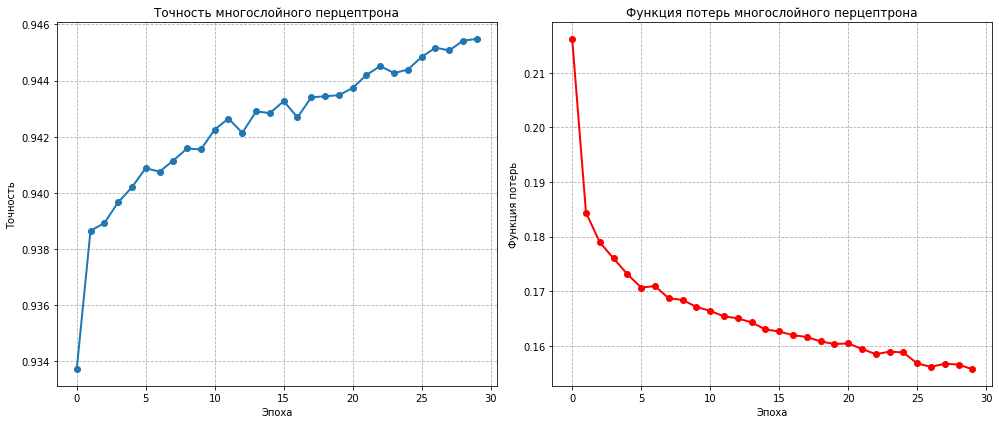

In [413]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(14, 6))

ax1.plot(mlp_model_history.history['accuracy'], zorder=2, lw=2, marker='o')
ax1.grid(True, ls='--')
ax1.set_title('Точность многослойного перцептрона')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Точность');

ax2.plot(mlp_model_history.history['loss'], zorder=2, lw=2, color='r', marker='o')
ax2.grid(True, ls='--')
ax2.set_title('Функция потерь многослойного перцептрона')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Функция потерь');

# Сравнение алгоритмов

In [ ]:
# plt.subplots(2)
pd.concat([mlp_lin_score['f1-score'], mlp_sigm_score['f1-score'], mlp_relu_score['f1-score']], 
          axis=1).plot(kind='bar', figsize=(12, 7), color=['r', 'orange', 'b'], ec='k', zorder=2)
plt.grid(True, axis='y')
plt.legend(['Линейная', 'Сигмоидная', 'Relu'], loc='best')
plt.xlabel('Классы')
plt.title(
    'Сравнение метрики f1-score для многослойного перцептрона с различными функциями активации'
);

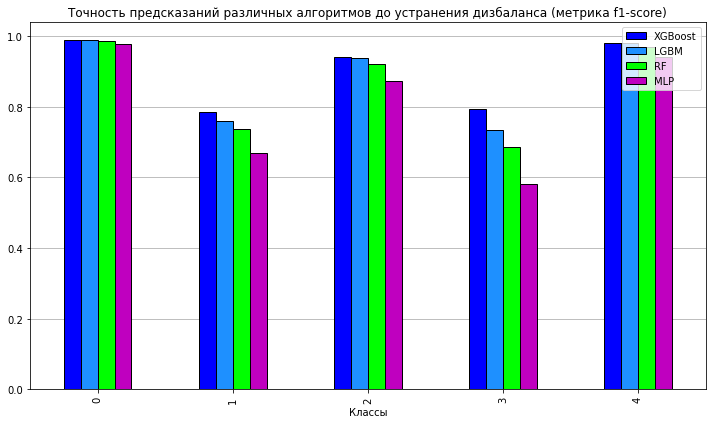

In [418]:
pd.concat([
    xgb_score.iloc[2], lgb_score.iloc[2], rf_score.iloc[2], mpl_score.iloc[2]
],
          axis=1).plot(kind='bar',
                       ec='k',
                       color=['b', 'dodgerblue', 'lime', 'm'], zorder=2)
plt.legend(['XGBoost', 'LGBM', 'RF', 'MLP'])
plt.grid(True, axis='y')
plt.title('Точность предсказаний различных алгоритмов до устранения дизбаланса (метрика f1-score)')
plt.xlabel('Классы');

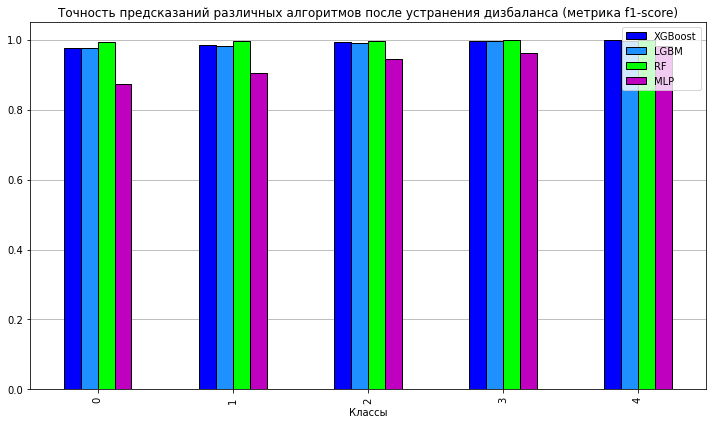

In [416]:
pd.concat([
    xgb_os_score.iloc[2], lgb_os_score.iloc[2], rf_os_score.iloc[2], mpl_os_score.iloc[2]
],
          axis=1).plot(kind='bar',
                       ec='k',
                       color=['b', 'dodgerblue', 'lime', 'm'], zorder=2)
plt.legend(['XGBoost', 'LGBM', 'RF', 'MLP'])
plt.grid(True, axis='y')
plt.title('Точность предсказаний различных алгоритмов после устранения дизбаланса (метрика f1-score)')
plt.xlabel('Классы');

Применение оверсемплинга значительно улучшило метрики алгоритмов классификации. Лучше всего себя показывают Random Forest и XGBoost